In [185]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

# from skimage import data
from skimage import transform as tf
from skimage.transform import rotate

import cv2

MIN_CONTOUR_AREA = 30
RESIZED_IMAGE_WIDTH = 20
RESIZED_IMAGE_HEIGHT = 30

SAMPLES_COUNT = 1002
SCORE_COLOR = [235,235,235]

# SAMPLE_FOLDER = 'F:\projlogs\gamcon_samples'
SAMPLE_FOLDER = "/mnt/hgfs/projlogs/gamcon_samples"

In [2]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

In [3]:
def show_raw(images, labels):
    fig, ax = plt.subplots(ncols=len(images), sharex=False, sharey=False)
    for i in range(len(images)):
        ax[i].imshow(images[i], cmap=plt.cm.gray)
        ax[i].axis('off')
        if labels is not None:
            ax[i].set_title(labels[i])

    plt.show()

In [4]:
def show_all(images, labels=None):
    if labels is not None:
        image_sets = list(grouper(images, 6, np.zeros(images[0].shape, dtype=np.int)))
        label_sets = list(grouper(labels, 6, ''))
        for i, image_set in enumerate(image_sets):
            show_raw(image_set, labels=label_sets[i])
    else:
        [ show_raw(z, ['']*6) for z in grouper(images, 6, np.zeros(images[0].shape, dtype=np.int)) ]

In [32]:
def preprocess_score_image(original, verbose=0):
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    _, bw_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    if verbose > 0:
        plt.imshow(bw_image);
        plt.show();
    image = bw_image.copy()
    img_contours, npa_contours, npa_hierarchy = cv2.findContours(image,
                                                 cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_SIMPLE)

    digits = []
    not_original = original.copy()
    for i, npa_contour in enumerate(npa_contours):
        if cv2.contourArea(npa_contour) > MIN_CONTOUR_AREA:
            [intX, intY, intW, intH] = cv2.boundingRect(npa_contour)
            if verbose > 0:
                print(i, [intX, intY, intW, intH])
            cv2.rectangle(not_original, (intX, intY), (intX+intW,intY+intH), (0, 0, 255), 1)
            if verbose > 0:
                plt.imshow(not_original);
                plt.show();
            imgROI = image[intY:intY+intH, intX:intX+intW]
            resized = cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
            flattened = resized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))
            digits.append((intX, flattened,))

    flattened_digits =  np.empty((0, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT), dtype=np.int)
    for _, digit in sorted(digits, key=lambda z: z[0]):
        flattened_digits = np.append(flattened_digits, digit, 0)

    return flattened_digits

In [6]:
# load classifications
classifications = []
with open(os.path.join(SAMPLE_FOLDER, 'score_smaples_values.txt'), 'rt') as f:
    test = [ z.strip() for z in f.readlines()]
    classifications = list(itertools.chain.from_iterable(test))
    # classifications.extend([z for z in chars])

print(len(test), test[:15])
print(sum([len(z) for z in test]))
print(len(classifications), classifications[:15])

1002 ['0', '0', '0', '0', '0', '0', '4', '12', '12', '16', '20', '28', '28', '28', '28']
3175
3175 ['0', '0', '0', '0', '0', '0', '4', '1', '2', '1', '2', '1', '6', '2', '0']


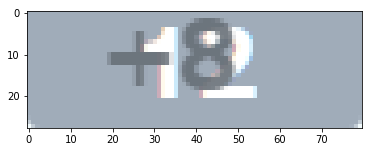

In [33]:
test_image = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_8.png'))
plt.imshow(test_image)

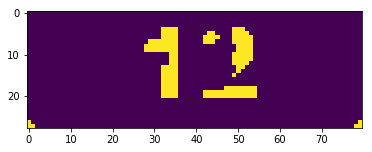

5 [28, 4, 8, 17]


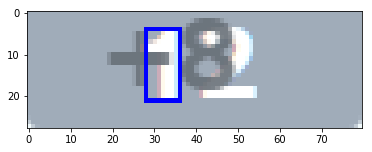

In [34]:
if MIN_CONTOUR_AREA < 30:
    MIN_CONTOUR_AREA = 30
parts = preprocess_score_image(test_image, verbose=1)

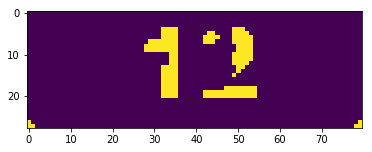

2 [42, 18, 13, 3]


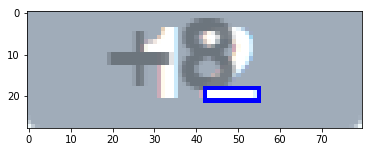

3 [42, 5, 4, 3]


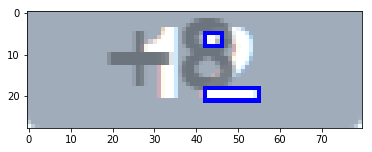

4 [49, 4, 5, 12]


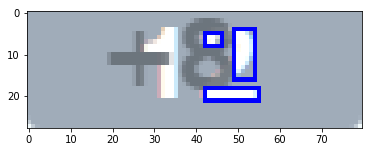

5 [28, 4, 8, 17]


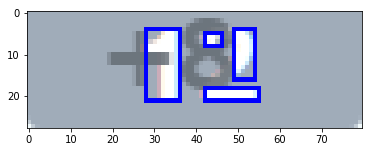

In [35]:
MIN_CONTOUR_AREA = 2
parts = preprocess_score_image(test_image, verbose=1)

In [96]:
test_image.shape

(28, 80, 3)

In [118]:
def col_filter(image, color, threshold=20):
    # filters specific color from the image
    lower = np.array([ z-threshold for z in color ])
    upper = np.array([ z+threshold for z in color ])
#     print('filtering by color range:', lower, upper)
    mask = cv2.inRange(image, lower, upper)
    res = cv2.bitwise_and(image, image, mask= mask)
    # cv2.GaussianBlur(res, (5,5), 0);
    res = cv2.medianBlur(res, 1);
    res = cv2.medianBlur(mask, 1);

    return res

In [251]:
def split_rois(image, color=[185, 172, 160], corner_cut_size=1, verbose=0):
    
    def find_range_start_end(sumlist):
        region_detected = False
        region_start = 0
        for i in range(len(sumlist)):
            if sumlist[i] > 0 and not region_detected:
                region_detected = True
                region_start = i

            if sumlist[i] == 0 and region_detected:
                break

        return region_start, i
    
    
    if verbose > 0:
        plt.imshow(image);
        plt.show();
        
    # filter by color
    workscreen = col_filter(image, color=color, threshold=20)
    
    if verbose > 0:
        plt.imshow(workscreen);
        plt.show();

    # sum over axis "0" i.e. sum the filterd color pixels in each column
    v_sums = workscreen.sum(0)
    if verbose > 0:
        print('h_sums lenght prior to corner cut:', len(v_sums))
    
    # cut corners (because of the round edges of the UI element, there are light color pixels in the corners of the img)
    v_sums = v_sums[corner_cut_size:-corner_cut_size]
    
    if verbose > 0:
        print(v_sums)
    
    zones = []
    consider_x = 0
    for delme in range(100):
        start_x, end_x = find_range_start_end(v_sums[consider_x:])
        
        # because find_range_start_end gives results relative to the input
        start_x +=  consider_x
        end_x += consider_x
        
        subimage = image[0:workscreen.shape[0], start_x:end_x + 1]
        consider_x = end_x + 1
        
        if verbose > 0:
            print(delme, start_x, end_x)
            
        zones.append([subimage, start_x, end_x])
        if start_x == consider_x or sum(v_sums[consider_x:]) == 0:
            break
    
    return zones

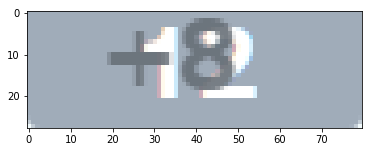

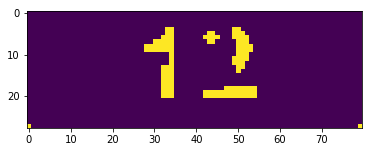

h_sums lenght prior to corner cut: 80
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  510
  510  765  765 3060 3570 4335    0    0    0    0    0    0    0  765
 1275 1275  765  510  765  765 2040 3570 3060 2295 1275  765    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
0 27 34
1 41 54
[[27, 34], [41, 54]]


In [132]:
zones = split_rois(test_image, color=[235,235,235], verbose=1)
print([z[1:] for z in zones ])
# plt.imshow(i);

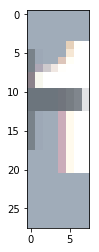

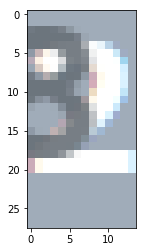

In [133]:
for sub in [ z[0] for z in zones ]:
    plt.imshow(sub);
    plt.show();

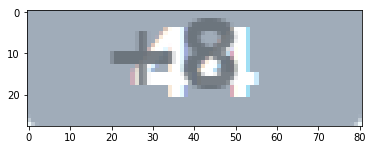

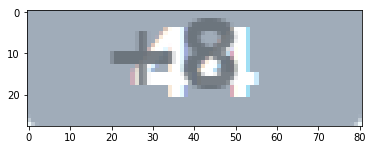

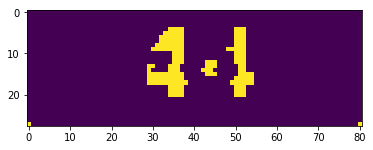

h_sums lenght prior to corner cut: 81
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 1275 1275 1275 1785 2040 3570 4335 4335 3825  255    0    0    0  255
 1020 1020  765    0    0  255  510 3570 4335 4335  765  765    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
0 28 38
1 41 45
2 47 54


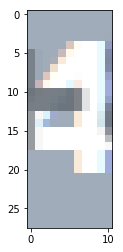

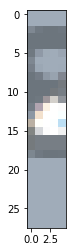

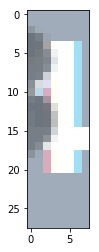

In [148]:
# ti2 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_344.png'))
# ti2 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_346.png'))
ti2 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_20.png'))
plt.imshow(ti2);
plt.show();
zones = split_rois(ti2, color=[235,235,235], verbose=1)
for sub in [ z[0] for z in zones ]:
    plt.imshow(sub);
    plt.show();

In [205]:
def merge_small_parts(zones, image, verbose=0):
    part_sizes = ([ z[2]-z[1] for z in zones ])
    new_zones = []
    
    if verbose > 0:
        print('# zones', len(zones))
    i = 1
    while i < len(zones) + 1:
        if verbose > 0:
            print('processing zones', i-1, '&', i)
        if part_sizes[i-1] < 7 and part_sizes[i] <= 11:
            subimage = image[0:image.shape[0], zones[i-1][1]:zones[i][2]+1]
            new_zones.append([subimage, zones[i-1][1], zones[i][2]])
            i += 1
            if verbose > 0:
                print('merged, thuse increased cycle to:', i-1, '&', i)
        else:
            new_zones.append(zones[i-1])
            
        i += 1
        if verbose > 0:
            print('ending=?', i, len(zones) +1, i == len(zones) +1 )
    
    if verbose > 0:
        print([z[1:] for z in new_zones])
    
    return new_zones  

In [250]:
def rois(image, corner_cut_size=1, verbose=0):
    zones = split_rois(image, color=SCORE_COLOR, corner_cut_size=corner_cut_size, verbose=verbose)
#     if verbose > 0:
#         print(len(zones))
    zones = merge_small_parts(zones, image, verbose=verbose)
#     if verbose > 0:
#         print(len(zones))
        
    return zones

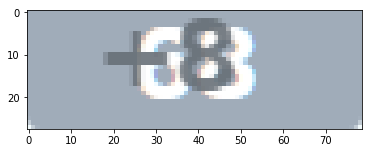

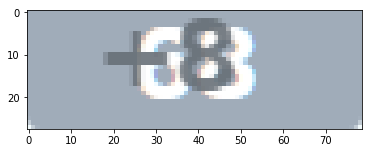

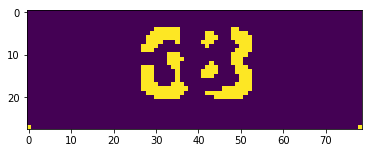

h_sums lenght prior to corner cut: 79
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 2040 2805
 3060 2295 1785 1530 2295 2805 3825 1020  255    0    0    0  765 2040
 2040 1275  510  765  765 2295 3570 4080 3315 2295    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
0 26 37
1 40 52
# zones 2
processing zones 0 & 1
ending=? 2 3 False
processing zones 1 & 2
ending=? 3 3 True
[[26, 37], [40, 52]]


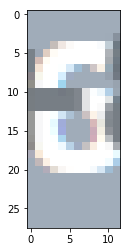

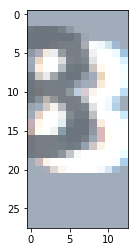

In [216]:
# ti3 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_344.png'))
# ti3 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_346.png'))
# ti3 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_20.png'))
ti3 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_43.png'))
plt.imshow(ti3);
plt.show();
# zones = split_rois(ti3, color=[235,235,235], verbose=1)
# zones = merge_small_parts(zones, ti3)
zones = rois(ti3, verbose=1)
for sub in [ z[0] for z in zones ]:
    plt.imshow(sub);
    plt.show();

In [69]:
FAIL HERE

SyntaxError: invalid syntax (<ipython-input-69-f2aac8727edc>, line 1)

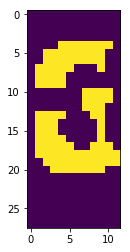

img smpls 1002


In [215]:
# load sample images
training_samples = []
training_images = []
flattened_images =  np.empty((0, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT), dtype=np.int)
classifications = []
for i in range(SAMPLES_COUNT):
    img = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_' + str(i+1) + '.png'))
    # training_images.extend(preprocess_score_image(img))
    training_samples.append(img)
#     parts = preprocess_score_image(img)
    parts = rois(img)
    if len(test[i]) != len(parts):
        print(i, len(test[i]), len(parts), '(', test[i], ')')
        show_raw([img, img], None)
    else:
        for j, part in enumerate(parts):
            classifications.append(test[i][j])
            gray = cv2.cvtColor(part[0], cv2.COLOR_BGR2GRAY)
            _, bw_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
            if i==42 and j==0:
                plt.imshow(bw_image);
                plt.show();
            
            resized = cv2.resize(bw_image, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
            flattened = resized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))
            flattened_images = np.append(flattened_images, flattened, 0)
    training_images.extend(parts)

print('img smpls', len(training_samples))

In [219]:
print('sample digits:', len(flattened_images), 'labels:', len(classifications))
classifications = [ int(z) for z in classifications]
np.savetxt("overlapping_classifications.txt", classifications, fmt='%i')
np.savetxt("overlapping_flattened_images.txt", flattened_images, fmt='%i')

sample digits: 3175 labels: 3175


In [ ]:
FAIL HERE

# LOAD AND TRAIN

In [241]:
# classifications = np.loadtxt("overlapping_classifications.txt") #, , fmt='%i')
with open('overlapping_classifications.txt', 'rt') as f:
    classifications = f.readlines()
flattened_images = np.loadtxt("overlapping_flattened_images.txt")#,  fmt='%i')

In [243]:
images = [ np.reshape(z, (RESIZED_IMAGE_HEIGHT, -1)) for z in flattened_images ]
classifications = [int(z.strip()) for z in classifications]

In [246]:
####  use this to output the loaded data  ####

# show_all(images, labels=classifications)

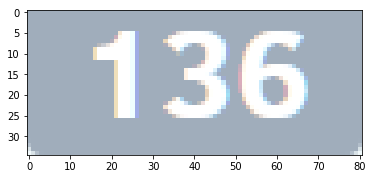

(35, 10, 3) (30, 20)
(35, 15, 3) (30, 20)
(35, 16, 3) (30, 20)


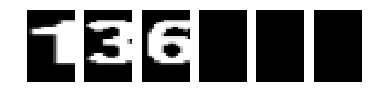

In [283]:
test_source = cv2.imread("samples/test_score.png")
plt.imshow(test_source, cmap=plt.cm.gray)
plt.show()

test = rois(test_source, corner_cut_size=2) #, verbose=1)
digits = []
for digit in test:
    
    gray = cv2.cvtColor(digit[0], cv2.COLOR_BGR2GRAY)
    _, bw_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    resized = cv2.resize(bw_image, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
    print(digit[0].shape, resized.shape)
    digits.append(resized)

# test_images = [ np.reshape(z, (RESIZED_IMAGE_HEIGHT, -1)) for z in digits ]
show_all(digits)

test_images = [z.reshape((RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT)) for z in digits]

In [284]:
digits[0].shape

(30, 20)

In [285]:
test_images[0].shape

(600,)

In [286]:
flattened_images[0].shape

(600,)

In [261]:
from sklearn import svm

In [263]:
# naive try without params
clf = svm.SVC()
clf.fit(flattened_images, classifications)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [294]:
# expect fail
for digit in test_images:
    predict = clf.predict([digit])
    print(predict)

[2]
[2]
[2]


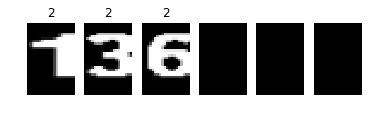

In [301]:
# just alternative display
predictions = [ clf.predict([z]).tolist() for z in test_images ]
show_all(digits, labels=[ str(z[0]) for z in predictions])

In [302]:
# Grid search

def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

more_params = {'clf__nu' : [0.8, 0.65, 0.5, 0.35, 0.2],
            'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', ],
            'clf__shrinking' : [True, False],
            'clf__tol' : [0.01, 0.003, 0.001, 0.0003, 0.0001],
            'clf__decision_function_shape' : ['ovo', 'ovr'],
        }

In [303]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [304]:
# # need more samples to have the CV
# double_samples = np.concatenate((flattened_images, flattened_images), axis=0)
# double_classes = np.concatenate((classifications, classifications), axis=0)

In [305]:
def grid_search():
    params = {
        'clf__random_state' : [1337]
    }

    params.update(more_params)

    pipeline = Pipeline([
        ('clf', svm.NuSVC())
    ])

    grid_search = GridSearchCV(pipeline, param_grid=params, cv=2, n_jobs=4)

    grid_search.fit(flattened_images, classifications )
    report(grid_search.cv_results_)

In [306]:
grid_search()

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f74cf8671e0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bob/.local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bob/.l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f74cf8671e0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bob/.local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bob/.l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid_search()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 16, 16, 32, 43, 120254, tzinfo=tzutc()), 'msg_id': 'BE00966CE6864F3A93B1A94A77ADA7FF', 'msg_type': 'execute_request', 'session': '35B580B51D4742128E9F9462C1EBB33B', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'BE00966CE6864F3A93B1A94A77ADA7FF', 'msg_type': 'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'35B580B51D4742128E9F9462C1EBB33B']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid_search()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 16, 16, 32, 43, 120254, tzinfo=tzutc()), 'msg_id': 'BE00966CE6864F3A93B1A94A77ADA7FF', 'msg_type': 'execute_request', 'session': '35B580B51D4742128E9F9462C1EBB33B', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'BE00966CE6864F3A93B1A94A77ADA7FF', 'msg_type': 'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'35B580B51D4742128E9F9462C1EBB33B'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid_search()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 16, 16, 32, 43, 120254, tzinfo=tzutc()), 'msg_id': 'BE00966CE6864F3A93B1A94A77ADA7FF', 'msg_type': 'execute_request', 'session': '35B580B51D4742128E9F9462C1EBB33B', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'BE00966CE6864F3A93B1A94A77ADA7FF', 'msg_type': 'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='grid_search()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'grid_search()'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('grid_search()',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('grid_search()',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='grid_search()', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-306-7ea50c2bdd1d>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f748785e240, executi..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f7487889f60, file "<ipython-input-306-7ea50c2bdd1d>", line 1>
        result = <ExecutionResult object at 7f748785e240, executi..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f7487889f60, file "<ipython-input-306-7ea50c2bdd1d>", line 1>, result=<ExecutionResult object at 7f748785e240, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f7487889f60, file "<ipython-input-306-7ea50c2bdd1d>", line 1>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import os\nimport math\nimport numpy as np\nimport ...MPLE_FOLDER = "/mnt/hgfs/projlogs/gamcon_samples"', 'def grouper(iterable, n, fillvalue=None):\n    "C...itertools.zip_longest(*args, fillvalue=fillvalue)', 'def show_raw(images, labels):\n    fig, ax = plt....       ax[i].set_title(labels[i])\n\n    plt.show()', 'def show_all(images, labels=None):\n    if labels...es, 6, np.zeros(images[0].shape, dtype=np.int)) ]', 'def preprocess_score_image(original, verbose=0):...ed_digits, digit, 0)\n\n    return flattened_digits', '# load classifications\nclassifications = []\nwith...print(len(classifications), classifications[:15])', "test_image = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_8.png'))\nplt.imshow(test_image)", 'if MIN_CONTOUR_AREA < 30:\n    MIN_CONTOUR_AREA =...s = preprocess_score_image(test_image, verbose=1)', 'MIN_CONTOUR_AREA = 2\nparts = preprocess_score_image(test_image, verbose=1)', 'print(parts)', 'FAIL HERE', 'if MIN_CONTOUR_AREA < 30:\n    MIN_CONTOUR_AREA =...s = preprocess_score_image(test_image, verbose=1)', 'def col_filter(image, color, threshold=20):\n    ...   res = cv2.medianBlur(mask, 5);\n\n    return res', 'def split_rois(image, grid_color=GRID_COLOR, ver..._screen, score_screen_start_x, score_screen_end_x', 'def split_rois(image, grid_color=[0,0,255], verb..._screen, score_screen_start_x, score_screen_end_x', 'split_rois(test_image, verbose=1)', 'def split_rois(image, grid_color=[0,0,255], verb..._screen, score_screen_start_x, score_screen_end_x', 'split_rois(test_image, verbose=1)', 'def split_rois(image, grid_color=[0,0,255], verb...kscreen, score_screen_start_x, score_screen_end_x', ...], 'MIN_CONTOUR_AREA': 30, 'Out': {7: <matplotlib.image.AxesImage object>, 20: (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 0, 79), 33: <matplotlib.image.AxesImage object>, 96: (28, 80, 3), 217: 3175, 224: array([0., 0., 0., 0., 0., 0., 4., 1., 2., 1., 2., 1., 6., 2., 0.]), 226: ['\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x04', '\x01', '\x02', '\x01', '\x02', '\x01', '\x06', '\x02', '\x00'], 227: ['\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x04', '\x01', '\x02', '\x01', '\x02', '\x01', '\x06', '\x02', '\x00'], 229: ['0\n', '0\n', '0\n', '0\n', '0\n', '0\n', '4\n', '1\n', '2\n', '1\n', '2\n', '1\n', '6\n', '2\n', '0\n'], 231: ['\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x04', '\x01', '\x02', '\x01', '\x02', '\x01', '\x06', '\x02', '\x00'], ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'RESIZED_IMAGE_HEIGHT': 30, 'RESIZED_IMAGE_WIDTH': 20, 'SAMPLES_COUNT': 1002, 'SAMPLE_FOLDER': '/mnt/hgfs/projlogs/gamcon_samples', 'SCORE_COLOR': [235, 235, 235], ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import os\nimport math\nimport numpy as np\nimport ...MPLE_FOLDER = "/mnt/hgfs/projlogs/gamcon_samples"', 'def grouper(iterable, n, fillvalue=None):\n    "C...itertools.zip_longest(*args, fillvalue=fillvalue)', 'def show_raw(images, labels):\n    fig, ax = plt....       ax[i].set_title(labels[i])\n\n    plt.show()', 'def show_all(images, labels=None):\n    if labels...es, 6, np.zeros(images[0].shape, dtype=np.int)) ]', 'def preprocess_score_image(original, verbose=0):...ed_digits, digit, 0)\n\n    return flattened_digits', '# load classifications\nclassifications = []\nwith...print(len(classifications), classifications[:15])', "test_image = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_8.png'))\nplt.imshow(test_image)", 'if MIN_CONTOUR_AREA < 30:\n    MIN_CONTOUR_AREA =...s = preprocess_score_image(test_image, verbose=1)', 'MIN_CONTOUR_AREA = 2\nparts = preprocess_score_image(test_image, verbose=1)', 'print(parts)', 'FAIL HERE', 'if MIN_CONTOUR_AREA < 30:\n    MIN_CONTOUR_AREA =...s = preprocess_score_image(test_image, verbose=1)', 'def col_filter(image, color, threshold=20):\n    ...   res = cv2.medianBlur(mask, 5);\n\n    return res', 'def split_rois(image, grid_color=GRID_COLOR, ver..._screen, score_screen_start_x, score_screen_end_x', 'def split_rois(image, grid_color=[0,0,255], verb..._screen, score_screen_start_x, score_screen_end_x', 'split_rois(test_image, verbose=1)', 'def split_rois(image, grid_color=[0,0,255], verb..._screen, score_screen_start_x, score_screen_end_x', 'split_rois(test_image, verbose=1)', 'def split_rois(image, grid_color=[0,0,255], verb...kscreen, score_screen_start_x, score_screen_end_x', ...], 'MIN_CONTOUR_AREA': 30, 'Out': {7: <matplotlib.image.AxesImage object>, 20: (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 0, 79), 33: <matplotlib.image.AxesImage object>, 96: (28, 80, 3), 217: 3175, 224: array([0., 0., 0., 0., 0., 0., 4., 1., 2., 1., 2., 1., 6., 2., 0.]), 226: ['\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x04', '\x01', '\x02', '\x01', '\x02', '\x01', '\x06', '\x02', '\x00'], 227: ['\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x04', '\x01', '\x02', '\x01', '\x02', '\x01', '\x06', '\x02', '\x00'], 229: ['0\n', '0\n', '0\n', '0\n', '0\n', '0\n', '4\n', '1\n', '2\n', '1\n', '2\n', '1\n', '6\n', '2\n', '0\n'], 231: ['\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x04', '\x01', '\x02', '\x01', '\x02', '\x01', '\x06', '\x02', '\x00'], ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'RESIZED_IMAGE_HEIGHT': 30, 'RESIZED_IMAGE_WIDTH': 20, 'SAMPLES_COUNT': 1002, 'SAMPLE_FOLDER': '/mnt/hgfs/projlogs/gamcon_samples', 'SCORE_COLOR': [235, 235, 235], ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/bob/gits/gamcon/<ipython-input-306-7ea50c2bdd1d> in <module>()
----> 1 grid_search()

...........................................................................
/home/bob/gits/gamcon/<ipython-input-305-471b8d13729a> in grid_search()
      9         ('clf', svm.NuSVC())
     10     ])
     11 
     12     grid_search = GridSearchCV(pipeline, param_grid=params, cv=2, n_jobs=4)
     13 
---> 14     grid_search.fit(flattened_images, classifications )
     15     report(grid_search.cv_results_)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=2, error_score='raise',
       e...ain_score='warn',
       scoring=None, verbose=0), X=array([[0., 0., 0., ..., 0., 0., 0.],
       [0...., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), y=[0, 0, 0, 0, 0, 0, 4, 1, 2, 1, 2, 1, 6, 2, 0, 2, 8, 2, 8, 2, ...], groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=2, random_state=None, shuffle=False)>
        X = array([[0., 0., 0., ..., 0., 0., 0.],
       [0...., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
        y = [0, 0, 0, 0, 0, 0, 4, 1, 2, 1, 2, 1, 6, 2, 0, 2, 8, 2, 8, 2, ...]
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Apr 16 09:33:13 2018
PID: 21772                                   Python 3.6.3: /usr/bin/python3
...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('clf', NuSVC(...7,
   shrinking=True, tol=0.01, verbose=False))]), memmap([[0., 0., 0., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), [0, 0, 0, 0, 0, 0, 4, 1, 2, 1, 2, 1, 6, 2, 0, 2, 8, 2, 8, 2, ...], {'score': <function _passthrough_scorer>}, array([1238, 1241, 1244, ..., 3172, 3173, 3174]), array([   0,    1,    2, ..., 1870, 1873, 1876]), 0, {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.8, 'clf__random_state': 1337, 'clf__shrinking': True, 'clf__tol': 0.01}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('clf', NuSVC(...7,
   shrinking=True, tol=0.01, verbose=False))]), memmap([[0., 0., 0., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), [0, 0, 0, 0, 0, 0, 4, 1, 2, 1, 2, 1, 6, 2, 0, 2, 8, 2, 8, 2, ...], {'score': <function _passthrough_scorer>}, array([1238, 1241, 1244, ..., 3172, 3173, 3174]), array([   0,    1,    2, ..., 1870, 1873, 1876]), 0, {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.8, 'clf__random_state': 1337, 'clf__shrinking': True, 'clf__tol': 0.01})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('clf', NuSVC(...7,
   shrinking=True, tol=0.01, verbose=False))]), X=memmap([[0., 0., 0., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), y=[0, 0, 0, 0, 0, 0, 4, 1, 2, 1, 2, 1, 6, 2, 0, 2, 8, 2, 8, 2, ...], scorer={'score': <function _passthrough_scorer>}, train=array([1238, 1241, 1244, ..., 3172, 3173, 3174]), test=array([   0,    1,    2, ..., 1870, 1873, 1876]), verbose=0, parameters={'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.8, 'clf__random_state': 1337, 'clf__shrinking': True, 'clf__tol': 0.01}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...,
   shrinking=True, tol=0.01, verbose=False))])>
        X_train = memmap([[0., 0., 0., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
        y_train = [3, 3, 3, 3, 3, 9, 9, 9, 3, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...]
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('clf', NuSVC(...7,
   shrinking=True, tol=0.01, verbose=False))]), X=memmap([[0., 0., 0., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), y=[3, 3, 3, 3, 3, 9, 9, 9, 3, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...], **fit_params={})
    245         self : Pipeline
    246             This estimator
    247         """
    248         Xt, fit_params = self._fit(X, y, **fit_params)
    249         if self._final_estimator is not None:
--> 250             self._final_estimator.fit(Xt, y, **fit_params)
        self._final_estimator.fit = <bound method BaseLibSVM.fit of NuSVC(cache_size...337,
   shrinking=True, tol=0.01, verbose=False)>
        Xt = memmap([[0., 0., 0., ..., 0., 0., 0.],
        [... 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
        y = [3, 3, 3, 3, 3, 9, 9, 9, 3, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...]
        fit_params = {}
    251         return self
    252 
    253     def fit_transform(self, X, y=None, **fit_params):
    254         """Fit the model and transform with the final estimator

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/svm/base.py in fit(self=NuSVC(cache_size=200, class_weight=None, coef0=0...1337,
   shrinking=True, tol=0.01, verbose=False), X=array([[0., 0., 0., ..., 0., 0., 0.],
       [0...., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), y=array([3., 3., 3., ..., 1., 8., 0.]), sample_weight=array([], dtype=float64))
    182         fit = self._sparse_fit if self._sparse else self._dense_fit
    183         if self.verbose:  # pragma: no cover
    184             print('[LibSVM]', end='')
    185 
    186         seed = rnd.randint(np.iinfo('i').max)
--> 187         fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
        fit = <bound method BaseLibSVM._dense_fit of NuSVC(cac...337,
   shrinking=True, tol=0.01, verbose=False)>
        X = array([[0., 0., 0., ..., 0., 0., 0.],
       [0...., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
        y = array([3., 3., 3., ..., 1., 8., 0.])
        sample_weight = array([], dtype=float64)
        solver_type = 1
        kernel = 'linear'
        seed = 1125387415
    188         # see comment on the other call to np.iinfo in this file
    189 
    190         self.shape_fit_ = X.shape
    191 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/svm/base.py in _dense_fit(self=NuSVC(cache_size=200, class_weight=None, coef0=0...1337,
   shrinking=True, tol=0.01, verbose=False), X=array([[0., 0., 0., ..., 0., 0., 0.],
       [0...., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), y=array([3., 3., 3., ..., 1., 8., 0.]), sample_weight=array([], dtype=float64), solver_type=1, kernel='linear', random_seed=1125387415)
    249                 class_weight=self.class_weight_, kernel=kernel, C=self.C,
    250                 nu=self.nu, probability=self.probability, degree=self.degree,
    251                 shrinking=self.shrinking, tol=self.tol,
    252                 cache_size=self.cache_size, coef0=self.coef0,
    253                 gamma=self._gamma, epsilon=self.epsilon,
--> 254                 max_iter=self.max_iter, random_seed=random_seed)
        self.max_iter = -1
        random_seed = 1125387415
    255 
    256         self._warn_from_fit_status()
    257 
    258     def _sparse_fit(self, X, y, sample_weight, solver_type, kernel,

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/svm/libsvm.cpython-36m-x86_64-linux-gnu.so in sklearn.svm.libsvm.fit()

ValueError: specified nu is infeasible
___________________________________________________________________________

In [ ]:
=-=--=-==--==--=--

Use the results from the grid search above to fill in the next training model:

In [ ]:
clf = svm.NuSVC(decision_function_shape='ovo', kernel='linear', nu=0.8, random_state=1337, shrinking=True, tol=0.01)
clf.fit(flattened_images, classifications)

reminder of the test sample

In [ ]:
show_all(test_images)

use the model to predict the test sample

In [ ]:
for digit in test:
    predict = clf.predict([digit])
    print(chr(int(predict)))

In [ ]:
predictions = [ clf.predict([z]) for z in test ]
show_all(test_images, labels=[ chr(z) for z in predictions])

SAVE it

In [ ]:
import pickle
with open('score_model2.pickle', 'wb') as f:
    pickle.dump(clf, f)

with open('score_model2.pickle', 'rb') as f:
    clf2 = pickle.load(f)
first_digit = clf2.predict([test[0]])
print('first digit of the score sample is', chr(first_digit))